# titiler-pgstac

As a part of the [OpenAerialMap modernization effort](https://www.hotosm.org/updates/openaerialmap-v2/), we've deployed an instance of [titiler-pgstac](https://github.com/stac-utils/titiler-pgstac).
This [titler](https://github.com/developmentseed/titiler) allows us to create dynamic mosaics using STAC API search queries.
In this notebook, we'll demonstrate how to create and use a dynamic mosaic for a single collection in the [Maxar open data catalog](https://registry.opendata.aws/maxar-open-data/).

## Inspection

Before creating the mosaic, let's use [pystac-client](https://github.com/stac-utils/pystac-client) and other tools to find and visualize the extents of the data we're going to use.
The [HOT OAM STAc catalog](https://hot-oam.ds.io/stac) includes a searchable [Collection of the Maxar open data STAC catalog](https://hot-oam.ds.io/stac/collections/maxar-opendata)

In [13]:
import urllib.parse
from pystac_client import Client

HOT_OAM_ROOT_URL = "https://hot-oam.ds.io"
HOT_OAM_STAC_URL = urllib.parse.urljoin(HOT_OAM_ROOT_URL, "stac")
client = Client.open(HOT_OAM_STAC_URL)
print("Collections:")
for collection in client.get_collections():
    print("-", collection.id)

Collections:
- maxar-opendata
- noaa-emergency-response
- openaerialmap


Each Maxar item includes a `catalog_id` attribute, which can be used to filter items to only a Catalog of interest.
If you know the `catalog_id`, you can skip this next step, but in many cases you'll need to find your `catalog_id`.
In this example, we'll look for all Maxar items that are over Colorado, USA, and figure out which `catalog_id` we want to use from there.

In [14]:
import json

COLORADO_BBOX = [-109.0591, 36.9928, -102.0421, 41.0020]
catalog_ids = {}
item_search = client.search(collections=["maxar-opendata"], bbox=COLORADO_BBOX)
for item in item_search.items():
    if item.properties["catalog_id"] not in catalog_ids:
        catalog_ids[item.properties["catalog_id"]] = item.properties["title"]

print(json.dumps(catalog_ids, indent=2))

{
  "10200100BCB1A500": "Marshall Fire - MXRA-Z13-031131113310"
}


Hey look, there's only one!

Now that we know the catalog id `10200100BCB1A500`, we can create a dynamic mosaic for that catalog id.
Before we do that, though, let's see what items we have for that `catalog_id`.
To do so, we'll use [cql2](https://www.ogc.org/standards/cql2/), an [OGC](https://www.ogc.org/) standard for querying spatial data.
CQL2 can be a bit klunky to write, especially in its more verbose **cql2-json** form, so we'll use the [cql2](https://github.com/developmentseed/cql2-rs/) helper library to turn easy-to-read text into **cql2-json**.

In [15]:
import cql2

cql2_text = "catalog_id='10200100BCB1A500'"
cql2_json = cql2.parse_text(cql2_text).to_json()
print(json.dumps(cql2_json, indent=2))

item_search = client.search(collections=["maxar-opendata"], filter=cql2_json)
item_collection = item_search.item_collection()

{
  "op": "=",
  "args": [
    {
      "property": "catalog_id"
    },
    "10200100BCB1A500"
  ]
}


We've got fifteen items, let's visualize their geometries on a simple map.

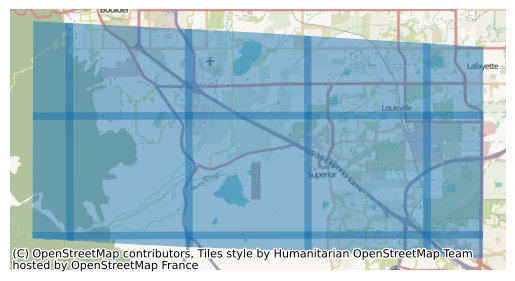

In [16]:
import contextily
from geopandas import GeoDataFrame

data_frame = GeoDataFrame.from_features(
    item_collection.to_dict(), crs="EPSG:4326"
)  # STAC items are always WGS84 because they're GeoJSON
axes = data_frame.to_crs(epsg=3857).plot(alpha=0.5)
contextily.add_basemap(axes)
axes.set_axis_off()

Now, let's create our dynamic mosaic.

## Dynamic mosaic

We'll use a new endpoint from **titiler-pgstac** (API documentation: <https://hot-oam.ds.io/raster/api.html>).
There isn't bespoke client, so we'll just use a generic one from **httpx**.
We'll POST to register a new search, and that search will include metadata that indicates that the dynamic mosaic should use the `visual` asset.

In [17]:
from httpx import Client

HOT_OAM_RASTER_URL = urllib.parse.urljoin(HOT_OAM_ROOT_URL, "raster/")

search = {
    "collections": ["maxar-opendata"],
    "filter": cql2_json,
    "metadata": {
        "assets": ["visual"]
    }
}

client = Client()
response = client.post(urllib.parse.urljoin(HOT_OAM_RASTER_URL, "searches/register"), json=search)
response.raise_for_status()
data = response.json()
print(json.dumps(data, indent=2))

{
  "id": "359817bbf399811f4824f47c011835e4",
  "links": [
    {
      "href": "https://hot-oam.ds.io/raster/searches/359817bbf399811f4824f47c011835e4/info",
      "rel": "metadata",
      "title": "Mosaic metadata"
    },
    {
      "href": "https://hot-oam.ds.io/raster/searches/359817bbf399811f4824f47c011835e4/{tileMatrixSetId}/tilejson.json",
      "rel": "tilejson",
      "templated": true,
      "title": "Link for TileJSON (Template URL)"
    },
    {
      "href": "https://hot-oam.ds.io/raster/searches/359817bbf399811f4824f47c011835e4/{tileMatrixSetId}/map",
      "rel": "map",
      "templated": true,
      "title": "Link for Map viewer (Template URL)"
    },
    {
      "href": "https://hot-oam.ds.io/raster/searches/359817bbf399811f4824f47c011835e4/{tileMatrixSetId}/WMTSCapabilities.xml",
      "rel": "wmts",
      "templated": true,
      "title": "Link for WMTS (Template URL)"
    }
  ]
}


We've now registered a search, with an ID, that we can use to create dynamic maps or WMTS endpoints.
You'll just need to do a couple things to that output url:

- Replace `{tileMatrixSetId}` with `WebMercatorQuad`
- Add an `?assets=visual` to the end to tell **titiler** what to render

TODO actually how how to load the WMTS, maybe into QGIS?

In [ ]:
link = next(link for link in data["links"] if link["rel"] == "wmts")
url = link["href"].replace(r"{tileMatrixSetId}", "WebMercatorQuad") + "?assets=visual"